# Introduction: Hyperparameter Optimization

In this notebook we will explore several options for hyperparameter optimization of a machine learning algorithm. We will start with some of the basic methods such as random search, and then proceed to more sophisticated methods using Guassian Processes.

In [1]:
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold

In [2]:
# Read in data and separate into training and testing sets
data = pd.read_csv('data/caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
labels = train_labels

print('Train shape: ', train.shape)

train.head()

Train shape:  (5822, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


# Random Search by Hand

The first method we can implement is simply random search. Each iteration, choose a random set of model hyperparameters from a search space. Empirically, random search is very effective, returning nearly as good results as grid search with a significant reduction in time spent searching. 

Random search can be implement in the Scikit-Learn library with the LightGBM Sklearn API. However, this does not support training with early stopping, which is the most effective method for determining the best number of iterations to use. Therefore, we will implement random search ourselves with a defined parameter grid, and using Early Stopping.

In [3]:
import random

In [4]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

# Domain 

In random search, as in Bayesian optimization, we have a domain over which we search for the best hyperparameters. In terms of a random or grid search, this is generally known as a hyperparameter grid

In [5]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 151)),
    'learning_rate': list(np.logspace(np.log(0.01), np.log(0.2), base = np.exp(1), num = 100)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

In [6]:
evals = 50

# Dataframe to hold cv results
results = pd.DataFrame(columns = ['params', 'train_scores', 'train', 'valid_scores', 'valid', 'estimators'],
                       index = list(range(evals)))

In [7]:
%%capture 
# Iterate through the specified number of evaluations
for i in range(evals):
    
    k_fold = KFold(n_splits = 5)
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    # Create the model with the parameters
    model = lgb.LGBMClassifier(class_weight = params['class_weight'], boosting_type = params['boosting_type'], 
                               num_leaves = params['num_leaves'], learning_rate = params['learning_rate'], 
                               subsample_for_bin = params['subsample_for_bin'], min_child_samples = params['min_child_samples'], 
                               reg_alpha = params['reg_alpha'], reg_lambda = params['reg_lambda'], 
                               colsample_by_tree = params['colsample_bytree'], subsample = params['subsample'], 
                               n_estimators = 10000, n_jobs = -1, objective = 'binary', verbose=-1, verbose_eval = False)
    
    # Empty lists for records
    valid_scores = []
    train_scores = []
    number_estimators = []
    
    # Split the data
    for (train_indices, valid_indices) in k_fold.split(features):
        
        # Training data and validation set
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Fit the model using early stopping
        model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  eval_metric = 'auc', eval_names = ['train', 'valid'], early_stopping_rounds = 200, verbose = -1);
        
        
        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        number_estimators.append(model.best_iteration_)
        
    # Average the scores
    valid = np.mean(valid_scores)
    train = np.mean(train_scores)
    estimators = np.mean(number_estimators)
    
    # Add results to next row in dataframe
    results.loc[i, :] = [params, train_scores, train, valid_scores, valid, estimators]

In [8]:
results = results.sort_values('valid', ascending = False)
results.head()

,params,train_scores,train,valid_scores,valid,estimators
22,"{'class_weight': 'balanced', 'boosting_type': ...","[0.8906003308793933, 0.8558370131244537, 0.888...",0.873115,"[0.7848923679060665, 0.7501188811188811, 0.761...",0.771327,39.8
1,"{'class_weight': None, 'boosting_type': 'gbdt'...","[0.8329243889656487, 0.8795007763511014, 0.849...",0.841323,"[0.777058056099152, 0.7655244755244756, 0.7653...",0.770526,41
17,"{'class_weight': 'balanced', 'boosting_type': ...","[0.8835527148046349, 0.9256136889845392, 0.919...",0.899154,"[0.7862752772341813, 0.7452657342657343, 0.761...",0.770208,59.2
30,"{'class_weight': None, 'boosting_type': 'gbdt'...","[0.8763761313397329, 0.9047325910738204, 0.890...",0.871686,"[0.772133072407045, 0.7643846153846154, 0.7626...",0.769959,63.8
32,"{'class_weight': 'balanced', 'boosting_type': ...","[0.8817968689674888, 0.865761139143768, 0.8735...",0.87193,"[0.778382257012394, 0.7474895104895105, 0.7618...",0.769956,90.8


In [9]:
results.iloc[0, 0]

{'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': 0.7333333333333333,
 'learning_rate': 0.19403866524532978,
 'min_child_samples': 270,
 'num_leaves': 74,
 'reg_alpha': 1.0,
 'reg_lambda': 0.3877551020408163,
 'subsample': 0.8080808080808082,
 'subsample_for_bin': 180000}

## Bayesian Hyperparameter Optimization using Hyperopt

In [10]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.stochastic import sample

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

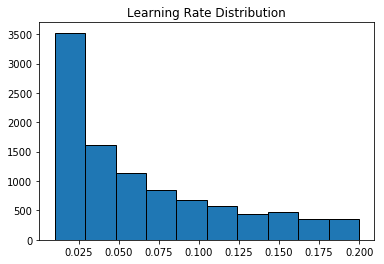

In [12]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))}
learning_rate_dist = []

for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.hist(learning_rate_dist, bins = 10, edgecolor = 'k');
plt.title('Learning Rate Distribution');

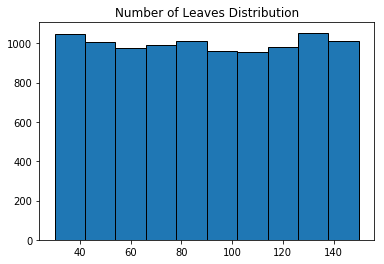

In [13]:
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
plt.hist(num_leaves_dist, bins = 10, edgecolor = 'k');
plt.title('Number of Leaves Distribution');

# Objective Function

The objective function will be the cross validation score evaluate over 5 folds. We need to make sure the objective function returns a single, real-value metric. We can return more information in the form of a dictionary where one of the keys must be 'loss' and another must be 'STATUS'. The other keys can hold information such as the hyperparameters used or the evaluation time.

In [14]:
import csv
from timeit import default_timer as timer

In [15]:
def objective(params):
    
    global iteration
    
    iteration += 1
    
    k_fold = KFold(n_splits = 5)
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    
    model = lgb.LGBMClassifier(n_estimators = 10000, **params, objective = 'binary', n_jobs = -1, verbose = -1)
    
    valid_scores = []
    train_scores = []
    number_estimators = []
    
    start = timer()
    for (train_indices, valid_indices) in k_fold.split(features):
        
        # Training data and validation set
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Fit the model using early stopping
        model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  eval_metric = 'auc', eval_names = ['train', 'valid'], early_stopping_rounds = 200, verbose = -1)
    
        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        number_estimators.append(model.best_iteration_)
        
    end = timer()
    
    run_time = end - start
    
    # fmin needs a loss to minimize
    valid = -1 * np.mean(valid_scores)
    train = -1 * np.mean(train_scores)
    
    # average number of estimators
    estimators = np.mean(number_estimators)

    o_f = open(out_file, 'a')
    writer = csv.writer(o_f)
    
    writer.writerow([valid, train, estimators, run_time, params, iteration])
    
    # Dictionary with information for evaluation
    return {'loss': valid, 'train': train, 'estimators': estimators, 
            'train_time': run_time, 'status': STATUS_OK, 'params': params}

In [16]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss'}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [17]:
boosting_type = {'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss'}])}

In [18]:
sample(boosting_type)

{'boosting_type': {'boosting_type': 'gbdt', 'subsample': 0.6440506964135775}}

In [19]:
sample(boosting_type)

{'boosting_type': {'boosting_type': 'goss'}}

In [20]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5))}

In [21]:
sample(learning_rate)

{'learning_rate': 0.30882886229848516}

In [22]:
sample(learning_rate)

{'learning_rate': 0.4050590135319103}

In [23]:
x = sample(space)

### Example of Sampling from the space

After finding the boosting type (which is in a nested dictionary), we assign the boosting type to make it a top level value. We use the dictionary get method to find the 'subsample' if it is in the dictionary (indicating the boosting type is 'gbdt' or 'dart') or set it to 1.0 otherwise (if boosting type is 'goss'). The goss boosting type cannot use bagging. 

This entire step is necessary because of the conditional logic used for the boosting type and subsample ratio.

In addition, we can see the other variables in the dictionary. These will change every time we sample the space.

In [24]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.9027644056192846,
 'learning_rate': 0.05087793626126211,
 'min_child_samples': 455.0,
 'num_leaves': 110.0,
 'reg_alpha': 0.20472634108516952,
 'reg_lambda': 0.4483519575330225,
 'subsample': 0.6622175250143509,
 'subsample_for_bin': 100000.0}

In [25]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.8123618729971422,
 'learning_rate': 0.025225385229030017,
 'min_child_samples': 45.0,
 'num_leaves': 77.0,
 'reg_alpha': 0.7615253222246864,
 'reg_lambda': 0.8984261853504442,
 'subsample': 1.0,
 'subsample_for_bin': 140000.0}

## Optimization

In [26]:
%%capture

out_file = 'gbm_trials1.csv'
iteration = 1

o_f = open(out_file, 'w')
writer = csv.writer(o_f)
writer.writerow(['loss', 'train', 'estimators', 'train_time', 'params', 'iteration'])
o_f.close()

trials = Trials()

best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 5, trials = trials, verbose = 1)

In [27]:
trials_results = sorted(trials.results, key = lambda x: x['loss'])

In [28]:
trials_results[:2]

[{'estimators': 177.0,
  'loss': -0.7697892949519953,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8834589981795999,
   'learning_rate': 0.054098718849793385,
   'min_child_samples': 470,
   'num_leaves': 116,
   'reg_alpha': 0.21352364067394936,
   'reg_lambda': 0.580483010352201,
   'subsample': 1.0,
   'subsample_for_bin': 20000},
  'status': 'ok',
  'train': -0.7926234865603419,
  'train_time': 2.1998353635087255},
 {'estimators': 35.6,
  'loss': -0.7684741746940057,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8794527985116436,
   'learning_rate': 0.12425640932943384,
   'min_child_samples': 375,
   'num_leaves': 88,
   'reg_alpha': 0.8957328991842315,
   'reg_lambda': 0.8001853323650469,
   'subsample': 0.6663096224369767,
   'subsample_for_bin': 300000},
  'status': 'ok',
  'train': -0.8207163854311504,
  'train_time': 2.190121582967917}]

In [29]:
import json

with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_results))

In [30]:
%%capture

out_file = 'gbm_trials2.csv'
iteration = 1

o_f = open(out_file, 'w')
writer = csv.writer(o_f)
writer.writerow(['loss', 'train', 'estimators', 'train_time', 'params', 'iteration'])
o_f.close()

trials = Trials()

best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 100, trials = trials, verbose = 1)

In [31]:
results = sorted(trials.results, key = lambda x: x['loss'], reverse = False)
results[:2]

[{'estimators': 92.4,
  'loss': -0.7752686691971785,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8154084655111529,
   'learning_rate': 0.050058208748931285,
   'min_child_samples': 410,
   'num_leaves': 59,
   'reg_alpha': 0.3822742768283194,
   'reg_lambda': 0.5402917976697761,
   'subsample': 1.0,
   'subsample_for_bin': 300000},
  'status': 'ok',
  'train': -0.7935511947345306,
  'train_time': 1.6708874441635544},
 {'estimators': 130.4,
  'loss': -0.7751144512486324,
  'params': {'boosting_type': 'dart',
   'class_weight': 'balanced',
   'colsample_bytree': 0.888739417843475,
   'learning_rate': 0.06477082605181578,
   'min_child_samples': 345,
   'num_leaves': 79,
   'reg_alpha': 0.4463268333467785,
   'reg_lambda': 0.6847851253810945,
   'subsample': 0.5705037973587046,
   'subsample_for_bin': 80000},
  'status': 'ok',
  'train': -0.814085792368501,
  'train_time': 7.958019970281214}]

In [32]:
%%capture

out_file = 'gbm_trials3.csv'
iteration = 1

o_f = open(out_file, 'w')
writer = csv.writer(o_f)
writer.writerow(['loss', 'train', 'estimators', 'train_time', 'params', 'iteration'])
o_f.close()

trials = Trials()

best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 200, trials = trials, verbose = 1)

In [33]:
results = sorted(trials.results, key = lambda x: x['loss'], reverse = False)
results[:2]

[{'estimators': 81.6,
  'loss': -0.7749768725306613,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8635474941572823,
   'learning_rate': 0.18914378933393633,
   'min_child_samples': 420,
   'num_leaves': 127,
   'reg_alpha': 0.41055129829119585,
   'reg_lambda': 0.9641296684543442,
   'subsample': 1.0,
   'subsample_for_bin': 120000},
  'status': 'ok',
  'train': -0.8074254510968052,
  'train_time': 1.3431077953728163},
 {'estimators': 279.8,
  'loss': -0.774727131513742,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8629181777645893,
   'learning_rate': 0.08153348413410726,
   'min_child_samples': 455,
   'num_leaves': 94,
   'reg_alpha': 0.43323582217647516,
   'reg_lambda': 0.7889969605386284,
   'subsample': 1.0,
   'subsample_for_bin': 60000},
  'status': 'ok',
  'train': -0.8012562358317634,
  'train_time': 3.930934024798262}]

# Conclusions

In this notebook, we saw how to use Hyperopt and the Tree Parzen Estimator to optimize the hyperparameters of a gradient boosting machine. Bayesian model-based optimization is more efficient than random search, finding a better set of model hyperparameters in fewer objective function (train-predict-evaluate) calls. In later notebooks we will examine using hyperparameter optimization on additional problems. 